In [11]:
import numpy as np
import pandas as pd
import os
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from _utils import u_constant
path = u_constant.PATH_ROOT + "for learn/Python/NLP_in_Action/chapter-8/sentiment-analysis/"

## 1. 读取词典

In [4]:
def load_word_data():
    word_list = np.load(path + "wordsList.npy")
    word_list = [word.decode("utf-8") for word in word_list]
    return word_list  

In [5]:
word_list = load_word_data()
print(len(word_list))

400000


In [6]:
# 有重复元素 '0'
word_map = {word: index for index, word in enumerate(word_list)}  # key: word, value: word_index
# len(word_map)  # 399999

## 2. 原始数据处理，生成TF训练样本

### 2.1 数据读取

In [10]:
def load_corpus():
    """
    读取文件夹下的训练样本文件，并整合为一个完整的数据集
    """
    result = []
    for _type in ["neg", "pos"]:
        label = 1 if _type == "pos" else 0
        folder_path = path + _type + "/"
        files = [folder_path + file for file in os.listdir(folder_path) if os.path.isfile(folder_path + file)]
        for file in files:
            with open(file, "r", encoding="utf-8") as f:
                text = " ".join(f.readlines()).strip()
                words_num = len(text.split())
                result.append((text, words_num, label))
                f.close()
        print("Load %s finished!" % _type)
    
    return pd.DataFrame(result, columns=["text", "words_num", "label"])        

In [11]:
data = load_corpus()
print(data[:5])
print(data["label"].value_counts())
data[["text", "label"]].to_csv(path + "data.txt", index=False, sep="\t")

Load neg finished!
Load pos finished!
                                                text  words_num  label
0  Story of a man who has unnatural feelings for ...        112      0
1  Airport '77 starts as a brand new luxury 747 p...        801      0
2  This film lacked something I couldn't put my f...        141      0
3  Sorry everyone,,, I know this is supposed to b...        154      0
4  When I was little my parents took me along to ...        395      0
1    12500
0    12500
Name: label, dtype: int64


### 2.2 探查词数分布

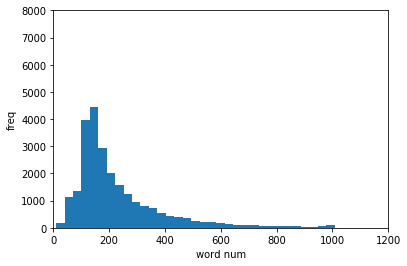

In [47]:
plt.hist(data["words_num"], bins=50)
plt.xlabel("word num")
plt.ylabel("freq")
plt.xlim(0, 1200)
plt.ylim(0, 8000)
plt.show()

### 2.3 生成索引矩阵

In [13]:
PATTERN = re.compile("[^A-Za-z0-9 ]+")
MAX_SEQ_LEN = 300
UNK_ID = 0

In [16]:
class MAT_Generator:
    
    def __init__(self, word_map, clean_pattern, max_seq_len, unk_id):
        self.word_map = word_map
        self.pattern = re.compile(clean_pattern)
        self.max_seq_len = max_seq_len
        self.unk_id = unk_id
    
    def clean_sentence(self, string):
        """
        清洗句子
        """
        string = string.lower().replace("<br />", " ")
        return self.pattern.sub("", string)
    
    def generate(self, texts):
        """
        为语料生成词索引矩阵
        :param texts: 语料集
        :return: 索引矩阵 (#texts, max_seq_len)
        """
        num_files = len(texts)
        # 矩阵初始化，全部元素都为缺省索引
        ids = np.full((num_files, self.max_seq_len), self.unk_id, dtype=np.int32)
        
        # 逐样本遍历
        for i, text in enumerate(texts):
            clean_text = self.clean_sentence(text)
            # 逐词遍历
            for j, word in enumerate(clean_text.split()):
                if j >= self.max_seq_len:
                    break
                try:
                    ids[i][j] = word_map[word]
                except KeyError:
                    pass
        return ids

In [17]:
# 打乱顺序
def one_hot(x, cate_num=None):
    """
    对一维数组进行one-hot
    :param cate_num: 类别数
    """
    x = np.asarray(x).astype(int)
    size = cate_num if cate_num is not None else max(x)
    return (np.arange(size) == x[:, np.newaxis]).astype(int)
texts = data["text"].values
labels = one_hot(data["label"].values, 2)
texts, labels = shuffle(texts, labels)

generator = MAT_Generator(word_map=word_map, clean_pattern=PATTERN, max_seq_len=MAX_SEQ_LEN, unk_id=UNK_ID)
ids_mat = generator.generate(texts)

print(ids_mat.shape)
print(ids_mat[:10])
print(labels[:10])
np.save(path + "ids_mat", ids_mat)
np.save(path + "labels", labels)

(25000, 300)
[[    91 201534   2807 ...      0      0      0]
 [     7    353    297 ...      0      0      0]
 [    58      3     64 ...      0      0      0]
 ...
 [    36   4855    102 ...      0      0      0]
 [  3202    192   1533 ...    285    518      7]
 [    37   1005     14 ...      0      0      0]]
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]]


## 3. TF训练

### 3.1 构建BATCH生成方法

In [13]:
ids_mat = np.load(path + "ids_mat.npy")
labels = np.load(path + "labels.npy")
word_vectors = np.load(path + "wordVectors.npy")
X_train, X_test, y_train, y_test = train_test_split(ids_mat, labels, test_size=0.1, random_state=0)
print(len(X_train))

22500


In [15]:
batch_size = 32
lstm_units = 64
NUM_LABELS = 2
MAX_SEQ_LEN = 300
lr = 0.001
epochs = 100

tf.reset_default_graph()
train_graph = tf.Graph()

with train_graph.as_default():    
    X = tf.placeholder(dtype=tf.int32, shape=[None, MAX_SEQ_LEN], name="inputs")
    y_ = tf.placeholder(dtype=tf.int32, shape=[None, NUM_LABELS], name="labels")
    
    embed = tf.nn.embedding_lookup(word_vectors, X, name="embedded_vectors")
    
    lstmCell = tf.contrib.rnn.BasicLSTMCell(num_units=lstm_units, activation=tf.nn.tanh)
    lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
    # RNN output: shape: [batch_size, max_seq_len, cell_num]
    value, _ = tf.nn.dynamic_rnn(cell=lstmCell, inputs=embed, dtype=tf.float32)
    # [lstm_units, num_labels]
    weight = tf.Variable(initial_value=tf.truncated_normal([lstm_units, NUM_LABELS]))
    # [-1, num_labels]
    bias = tf.Variable(tf.constant(0.1, shape=[1, NUM_LABELS]))
    # [max_seq_len, batch_size, lstm_units]
    value = tf.transpose(value, [1, 0, 2])  
    
    # 取最后一个输出 [batch_size, lstm_units]
    last = tf.gather(params=value, indices=int(value.get_shape()[0] - 1), axis=0)  
    
    y = last @ weight + bias  # logit 不用 softmax进行计算，都包裹在cross_entropy_with_logit中了
    correct_pred = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32), name="ACC")
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
    saver = tf.train.Saver()
    
    tf.summary.scalar("Loss", loss)
    tf.summary.scalar("ACC", accuracy)
    merged = tf.summary.merge_all()
    
      

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [16]:
def generate_batch(X, y, batch_size):
    """
    生成batch
    """
    assert len(X) == len(y), "features num doesn't match labels num!"
    total_length = (len(y) // batch_size) * batch_size
    X = X[:total_length]
    y = y[:total_length]
    
    for curr in range(0, total_length, batch_size):
        batchx = X[curr : curr + batch_size]
        batchy = y[curr : curr + batch_size]
        yield batchx, batchy    
        
def get_iternum_from_ckpt(ckpt_path):
    with open(ckpt_path + "checkpoint", "r", encoding="utf-8") as f:
        model_info = f.__next__().strip().rstrip('"')
        iters = model_info.split(".ckpt-")[1]
        return int(iters)

In [ ]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8  # 程序最多只能占用指定gpu70%的显存
config.gpu_options.allow_growth = True      #程序按需申请内存
log_path = u_constant.PATH_ROOT + "board/lstm/"
ckpt_path = path + "models/"

with tf.Session(graph=train_graph, config=config) as sess:
    sess.graph.finalize()
    train_writer = tf.summary.FileWriter(log_path + "train", graph=sess.graph)
    test_writer = tf.summary.FileWriter(log_path + "test") 
    
    if os.path.exists(ckpt_path) and os.path.exists(ckpt_path + "checkpoint"):
        saver.restore(sess, tf.train.latest_checkpoint(ckpt_path))
        iteration = get_iternum_from_ckpt(ckpt_path)
    else:
        sess.run(tf.global_variables_initializer())
        iteration = 1
    start = time.time()
    avg_loss = 0
    for epoch in range(epochs):
        train_batches = generate_batch(X_train, y_train, batch_size=batch_size)
        for batch_x, batch_y in train_batches:
            summary, _, train_loss = sess.run([merged, optimizer, loss], 
                                                  feed_dict={X: batch_x, y_: batch_y})
            avg_loss += train_loss 
            
            if iteration % 10 == 9: # 每 100次记录到 train中
                train_writer.add_summary(summary, iteration)              
            if iteration % 100 == 0: # 每 1000次输出训练进度结果并保存模型
                end = time.time()
                summary, acc = sess.run([merged, accuracy], 
                                        feed_dict={X: X_test, y_: y_test})
                test_writer.add_summary(summary, iteration)
                print("Iterations: %d " % (iteration), 
                      "Avg. Train_loss: %.4f " % (avg_loss / 100), 
                      "%.4f sec / batch" % ((end - start) / 100), 
                      "test acc iter %d: %.4f" % (iteration, acc))
                
                save_path = saver.save(sess, path + "models/lstm.ckpt", global_step=iteration)
                avg_loss = 0
                start = time.time()
            
            iteration += 1
train_writer.close()
test_writer.close() 

INFO:tensorflow:Restoring parameters from F:/for learn/Python/NLP_in_Action/chapter-8/sentiment-analysis/models/lstm.ckpt-2200
Iterations: 2200  Avg. Train_loss: 0.0066  0.0209 sec / batch test acc iter 2200: 0.5232
Iterations: 2300  Avg. Train_loss: 0.6774  0.5414 sec / batch test acc iter 2300: 0.5248
Iterations: 2400  Avg. Train_loss: 0.6551  0.6282 sec / batch test acc iter 2400: 0.5972
Iterations: 2500  Avg. Train_loss: 0.6606  0.6417 sec / batch test acc iter 2500: 0.6952
Iterations: 2600  Avg. Train_loss: 0.6524  0.5684 sec / batch test acc iter 2600: 0.5316
Iterations: 2700  Avg. Train_loss: 0.6720  0.6098 sec / batch test acc iter 2700: 0.5664
